# Importing Necessary modules

In [ ]:
import numpy as np
from keras.models import Sequential,load_model
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import pandas as pd
from keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import OneHotEncoder
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout, concatenate
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Data Pre-processing

In [ ]:
# Load the dataset
df = pd.read_csv("/content/LSTM_Model_all_crops.csv")

# Shuffle the DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Extract NDVI values and replace values less than 0.1 with NaN
ndvi_df = df.iloc[:, 3:].mask(df.iloc[:, 3:] < 0.1)

# Interpolate NaN values
def interpolate_nan(row):
    for i in range(len(row)):
        if pd.isna(row[i]):
            prev_idx = i - 1
            while prev_idx >= 0 and pd.isna(row[prev_idx]):
                prev_idx -= 1
            next_idx = i + 1
            while next_idx < len(row) and pd.isna(row[next_idx]):
                next_idx += 1
            if prev_idx >= 0 and next_idx < len(row):
                interpolated_value = (row[prev_idx] + row[next_idx]) / 2
                row[i] = interpolated_value
            else:
                row[i] = 0.1
    return row

ndvi_df = ndvi_df.apply(interpolate_nan, axis=1)

# Extract crop names column
crop_names = df['CropName']

# One-hot encode crop names
one_hot_encoder = OneHotEncoder(sparse=False)
encoded_crop_names = one_hot_encoder.fit_transform(crop_names.values.reshape(-1, 1))
crop_names_categories = one_hot_encoder.categories_[0]
encoded_crop_names_df = pd.DataFrame(encoded_crop_names, columns=[f'Encoded_Crop_{crop}' for crop in crop_names_categories])

# Check if the encoding was successful
encoded_crop_names_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Encoded_Crop_Bajra,Encoded_Crop_Cotton,Encoded_Crop_Gram,Encoded_Crop_Ground Nut,Encoded_Crop_Maize,Encoded_Crop_Mustard,Encoded_Crop_Onion,Encoded_Crop_Potato,Encoded_Crop_Rice,Encoded_Crop_Soyabean,Encoded_Crop_Wheat
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Input-Output Sequences

In [ ]:
# Define input sequence length (L) and output sequence length (M)
L = 9
M = 3

# Extract relevant columns from the DataFrame
df_subset = df[['area', 'field_id', 'CropName']]

# Concatenate NDVI values with encoded crop names
data = pd.concat([df_subset, encoded_crop_names_df, ndvi_df], axis=1)

# Initialize lists to store input-output pairs
input_sequences = []
output_sequences = []

# Iterate over each row in the dataset
for _, row in data.iterrows():
    crop_name = row['CropName']
    ndvi_values = row.iloc[3+crop_names_categories.size:].values  # Extract NDVI values
    encoded_crop_name = row.iloc[3:3+crop_names_categories.size].values  # Extract one-hot encoded crop name

    # Create input-output pairs using sliding window approach
    for i in range(len(ndvi_values) - L - M + 1):
        input_seq = ndvi_values[i:i + L]  # Extract input sequence
        output_seq = ndvi_values[i + L:i + L + M]  # Extract output sequence

        # Append input and output sequences to the respective lists
        input_sequences.append(list(input_seq) + list(encoded_crop_name))
        output_sequences.append(list(output_seq))

# Convert lists to pandas DataFrames
input_df = pd.DataFrame(input_sequences, columns=[f"NDVI_{i}" for i in range(1, L + 1)] + [f"Encoded_Crop_{crop}" for crop in crop_names_categories])
output_df = pd.DataFrame(output_sequences, columns=[f"NDVI_{i}" for i in range(L + 1, L + M + 1)])

# Concatenate input and output DataFrames
input_output_df = pd.concat([input_df, output_df], axis=1)

# Print the resulting input-output pairs
input_output_df



,NDVI_1,NDVI_2,NDVI_3,NDVI_4,NDVI_5,NDVI_6,NDVI_7,NDVI_8,NDVI_9,Encoded_Crop_Bajra,...,Encoded_Crop_Maize,Encoded_Crop_Mustard,Encoded_Crop_Onion,Encoded_Crop_Potato,Encoded_Crop_Rice,Encoded_Crop_Soyabean,Encoded_Crop_Wheat,NDVI_10,NDVI_11,NDVI_12
0,0.155200,0.155800,0.242800,0.245267,0.319867,0.243933,0.289200,0.264000,0.418667,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.210067,0.214333,0.218600
1,0.155800,0.242800,0.245267,0.319867,0.243933,0.289200,0.264000,0.418667,0.210067,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.214333,0.218600,0.297667
2,0.242800,0.245267,0.319867,0.243933,0.289200,0.264000,0.418667,0.210067,0.214333,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.218600,0.297667,0.337200
3,0.245267,0.319867,0.243933,0.289200,0.264000,0.418667,0.210067,0.214333,0.218600,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.297667,0.337200,0.376733
4,0.319867,0.243933,0.289200,0.264000,0.418667,0.210067,0.214333,0.218600,0.297667,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.337200,0.376733,0.369933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43296,0.497743,0.527943,0.562781,0.622743,0.236619,0.588590,0.438533,0.401552,0.222267,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.323790,0.285781,0.266695
43297,0.527943,0.562781,0.622743,0.236619,0.588590,0.438533,0.401552,0.222267,0.323790,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.285781,0.266695,0.165343
43298,0.562781,0.622743,0.236619,0.588590,0.438533,0.401552,0.222267,0.323790,0.285781,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.266695,0.165343,0.187371
43299,0.622743,0.236619,0.588590,0.438533,0.401552,0.222267,0.323790,0.285781,0.266695,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.165343,0.187371,0.184857


# Reshaping Input sequences

In [ ]:
# Split the data into features (input) and target (output)
X = input_df.values
y = output_df.values

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape X_train for LSTM input
X_train = X_train.reshape(X_train.shape[0], L + len(crop_names_categories), -1)

# Reshape X_val for LSTM input
X_val = X_val.reshape(X_val.shape[0], L + len(crop_names_categories), -1)

# Model Architecture

In [ ]:
# Define input for NDVI sequence
ndvi_input = Input(shape=(L, 1), name='ndvi_input')

# LSTM layers for processing NDVI sequence
lstm_output = LSTM(units=128, return_sequences=True)(ndvi_input)  # Increased units and added return_sequences=True
lstm_output = Dropout(0.2)(lstm_output)

# Adding another LSTM layer
lstm_output = LSTM(units=128, return_sequences=True)(lstm_output)  # Increased units and added return_sequences=True
lstm_output = Dropout(0.2)(lstm_output)

# Adding one more LSTM layer
lstm_output = LSTM(units=128)(lstm_output)  # Increased units
lstm_output = Dropout(0.2)(lstm_output)

# Define input for encoded crop names
crop_input = Input(shape=(len(crop_names_categories),), name='crop_input')
# Dense layer for processing encoded crop names
crop_output = Dense(64, activation='relu')(crop_input)

# Merge the outputs of the two branches
merged = concatenate([lstm_output, crop_output])

# Additional Dense layers for further processing
merged = Dense(64, activation='relu')(merged)
merged = Dropout(0.2)(merged)

# Output layer
output = Dense(M, name='output')(merged)

# Define the model
model = Model(inputs=[ndvi_input, crop_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Print model summary
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 ndvi_input (InputLayer)     [(None, 9, 1)]               0         []                            
                                                                                                  
 lstm_3 (LSTM)               (None, 9, 128)               66560     ['ndvi_input[0][0]']          
                                                                                                  
 dropout_4 (Dropout)         (None, 9, 128)               0         ['lstm_3[0][0]']              
                                                                                                  
 lstm_4 (LSTM)               (None, 9, 128)               131584    ['dropout_4[0][0]']           
                                                                                            

In [ ]:
# Train the model
history = model.fit([X_train[:, :L], X_train[:, L:]], y_train, epochs=80, batch_size=30, validation_data=([X_val[:, :L], X_val[:, L:]], y_val))


Epoch 1/80
1155/1155 [==============================] - 78s 62ms/step - loss: 0.0199 - val_loss: 0.0140
Epoch 2/80
1155/1155 [==============================] - 65s 57ms/step - loss: 0.0146 - val_loss: 0.0126
Epoch 3/80
1155/1155 [==============================] - 64s 56ms/step - loss: 0.0129 - val_loss: 0.0121
Epoch 4/80
1155/1155 [==============================] - 65s 56ms/step - loss: 0.0118 - val_loss: 0.0100
Epoch 5/80
1155/1155 [==============================] - 65s 56ms/step - loss: 0.0109 - val_loss: 0.0092
Epoch 6/80
1155/1155 [==============================] - 64s 55ms/step - loss: 0.0105 - val_loss: 0.0093
Epoch 7/80
1155/1155 [==============================] - 64s 56ms/step - loss: 0.0101 - val_loss: 0.0089
Epoch 8/80
1155/1155 [==============================] - 66s 57ms/step - loss: 0.0098 - val_loss: 0.0085
Epoch 9/80
1155/1155 [==============================] - 65s 56ms/step - loss: 0.0094 - val_loss: 0.0081
Epoch 10/80
1155/1155 [==============================] - 64s 56m

In [ ]:

# Evaluate the model
train_loss = model.evaluate([X_train[:, :L], X_train[:, L:]], y_train, verbose=0)
val_loss = model.evaluate([X_val[:, :L], X_val[:, L:]], y_val, verbose=0)
print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Training Loss: 0.0024, Validation Loss: 0.0045


# Evaluating Model

In [ ]:

# Predict on validation set
y_pred = model.predict([X_val[:, :L], X_val[:, L:]])

# Flatten y_val and y_pred
y_val_flat = y_val.flatten()
y_pred_flat = y_pred.flatten()

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_val_flat, y_pred_flat)
rmse = mean_squared_error(y_val_flat, y_pred_flat, squared=False)
print("MAE:", mae)
print("RMSE:", rmse)


271/271 [==============================] - 7s 21ms/step
MAE: 0.04375640458555469
RMSE: 0.0670750677908832


# Save Model and Encoder

In [ ]:
model.save("LSTM_NDVI_all_crops_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
!pip install joblib

In [ ]:
import joblib
# Save the encoder
joblib.dump(one_hot_encoder, "all_crops_one_hot_encoder.joblib")

['all_crops_one_hot_encoder.joblib']

# Validating on New Dataset

In [ ]:
!pip install joblib

In [ ]:
import joblib
# Load the encoder
one_hot_encoder = joblib.load("/content/all_crops_one_hot_encoder.joblib")
model = load_model("/content/LSTM_NDVI_all_crops_model.h5")

In [ ]:
# Load the new unseen data
new_data = pd.read_csv('/content/onion_2024_LSTM_test_data.csv')

In [ ]:
new_data

,CropName,Farm_Name,Transplanting,NDVI_1,NDVI_2,NDVI_3,NDVI_4,NDVI_5,NDVI_6,NDVI_7,...,NDVI_21,NDVI_22,NDVI_23,NDVI_24,NDVI_25,NDVI_26,NDVI_27,NDVI_28,Unnamed: 31,Unnamed: 32
0,Onion,Gj53,25-10-2023,0.086320,0.350042,0.332343,0.264023,0.264963,0.224703,0.205440,...,0.395497,0.279197,0.402000,0.390913,0.400630,0.332830,0.284217,0.200420,NaN,NaN
1,Onion,Gj153,17-11-2023,0.124365,0.111414,0.162718,0.140610,0.143740,0.140930,0.137513,...,0.424040,0.479362,0.277760,0.331842,0.454345,0.414070,0.319234,0.179464,NaN,NaN
2,Onion,Gj56,20-11-2023,0.119615,0.205194,0.183864,0.185520,0.201476,0.199977,0.177650,...,0.332561,0.235967,0.329050,0.272771,0.222267,0.174038,0.125332,0.122434,NaN,NaN
3,Onion,Gj44,10-10-2023,0.208973,0.235501,0.268780,0.267411,0.243527,0.252645,0.230368,...,0.460173,0.301486,0.363848,0.282577,0.239518,0.206368,0.176468,0.162664,NaN,NaN
4,Onion,Gj116,18-10-2023,0.160000,0.220000,0.214685,0.219379,0.214630,0.205566,0.205666,...,0.405622,0.300925,0.391397,0.389036,0.368505,0.321218,0.223948,0.171816,NaN,NaN
5,Onion,0.314119125,190,0.121633,0.159842,0.156334,0.142143,0.142597,0.194940,0.227299,...,0.173278,0.042242,0.235925,0.162707,0.217743,0.134475,0.112269,0.093287,0.090958,0.084663
6,Onion,0.323022406,191,0.118081,0.163383,0.151075,0.145903,0.150914,0.185303,0.221783,...,0.198444,0.045353,0.324397,0.302828,0.238558,0.137222,0.117108,0.103928,0.096625,0.087100
7,Onion,0.976032662,192,0.162013,0.294990,0.306108,0.306598,0.226760,0.380444,0.450571,...,0.190410,0.053461,0.257398,0.086078,0.222294,0.148764,0.136038,0.119324,0.108450,0.102506
8,Onion,1.321165252,193,0.148555,0.260542,0.256776,0.262238,0.206498,0.314596,0.393999,...,0.200274,0.053021,0.375536,0.131317,0.298593,0.217367,0.156696,0.126994,0.116816,0.115801
9,Onion,0.257752883,194,0.191147,0.289274,0.273491,0.238691,0.187979,0.269656,0.295063,...,0.158674,0.035765,0.236789,0.323035,0.265425,0.297726,0.292151,0.277891,0.234551,0.232449


In [ ]:

new_data = new_data.head(5)
# Define input sequence length (L) and output sequence length (M)
L = 9  # Adjust according to your model input size

# Extract NDVI values from the new dataset
ndvi_df = new_data.iloc[:, 3:].mask(new_data.iloc[:, 3:] < 0.1)

# Interpolate NaN values
def interpolate_nan(row):
    for i in range(len(row)):
        if pd.isna(row[i]):
            prev_idx = i - 1
            while prev_idx >= 0 and pd.isna(row[prev_idx]):
                prev_idx -= 1
            next_idx = i + 1
            while next_idx < len(row) and pd.isna(row[next_idx]):
                next_idx += 1
            if prev_idx >= 0 and next_idx < len(row):
                interpolated_value = (row[prev_idx] + row[next_idx]) / 2
                row[i] = interpolated_value
            else:
                row[i] = 0.1
    return row

ndvi_df = ndvi_df.apply(interpolate_nan, axis=1)
ndvi_df1 = np.array(ndvi_df.iloc[:,3:3+L])

# Extract crop names column
crop_names = new_data['CropName']

# One-hot encode crop names
encoded_crop_names = one_hot_encoder.transform(crop_names.values.reshape(-1, 1))
crop_names_categories = one_hot_encoder.categories_[0]
encoded_crop_names_df = pd.DataFrame(encoded_crop_names, columns=[f'Encoded_Crop_{crop}' for crop in one_hot_encoder.categories_[0]])

In [ ]:
input_seq = ndvi_df1.reshape(ndvi_df1.shape[0], L, 1)

# Repeat the process M times
for i in range(7):
    # Predict on the new data
    predicted_values2 = model.predict([input_seq[:, -L:].reshape(input_seq.shape[0], L, 1), encoded_crop_names[:, :].reshape(encoded_crop_names.shape[0], encoded_crop_names.shape[1], 1)])

    # Update the input sequence and predicted values
    predicted_values2 = predicted_values2.reshape(predicted_values2.shape[0], predicted_values2.shape[1], 1)  # Reshape to match the dimensions of input_seq
    input_seq = np.concatenate([input_seq, predicted_values2], axis=1)


reshaped_enco_crop = encoded_crop_names[:, :].reshape(encoded_crop_names.shape[0], encoded_crop_names.shape[1], 1)
predicted_val = np.concatenate([input_seq, reshaped_enco_crop], axis=1)


1/1 [==============================] - 0s 25ms/step


In [ ]:
# Convert the concatenated result into a DataFrame
num_ndvi_columns = predicted_val.shape[1] - len(crop_names_categories)  # Number of NDVI columns
column_names = [f"NDVI_{i}" for i in range(1, num_ndvi_columns + 1)]
df_result = pd.DataFrame(predicted_val[:, :num_ndvi_columns, 0], columns=column_names)

# Decode encoded crop names to original names
decoded_crop_names = one_hot_encoder.inverse_transform(encoded_crop_names)

# Create a DataFrame for decoded crop names
df_crop_names = pd.DataFrame(decoded_crop_names, columns=['CropName'])

# Concatenate the decoded crop names DataFrame with the result DataFrame
df_final_result = pd.concat([df_crop_names, df_result], axis=1)

# Renaming NDVI columns
ndvi_column_indices = [i for i, col in enumerate(df_final_result.columns) if 'NDVI' in col]
for i, idx in enumerate(ndvi_column_indices):
    df_final_result.rename(columns={df_final_result.columns[idx]: f"NDVI_{i + 1}"}, inplace=True)


# Display the final result DataFrame
df_final_result

,CropName,NDVI_1,NDVI_2,NDVI_3,NDVI_4,NDVI_5,NDVI_6,NDVI_7,NDVI_8,NDVI_9,...,NDVI_21,NDVI_22,NDVI_23,NDVI_24,NDVI_25,NDVI_26,NDVI_27,NDVI_28,NDVI_29,NDVI_30
0,Onion,0.264023,0.264963,0.224703,0.205440,0.198123,0.204380,0.192350,0.154657,0.212983,...,0.273579,0.239255,0.254824,0.262289,0.241341,0.239413,0.230631,0.209157,0.204457,0.192098
1,Onion,0.140610,0.143740,0.140930,0.137513,0.139408,0.118353,0.133890,0.123348,0.166475,...,0.360998,0.325762,0.319025,0.268286,0.253489,0.261247,0.196511,0.193047,0.192679,0.184917
2,Onion,0.185520,0.201476,0.199977,0.177650,0.180438,0.194823,0.194951,0.157137,0.204814,...,0.279080,0.241474,0.233056,0.218258,0.226521,0.216083,0.199255,0.206960,0.222638,0.222623
3,Onion,0.267411,0.243527,0.252645,0.230368,0.218427,0.244505,0.202752,0.149625,0.269473,...,0.181084,0.171876,0.186567,0.186622,0.188873,0.199251,0.193442,0.190683,0.202521,0.196380
4,Onion,0.219379,0.214630,0.205566,0.205666,0.240842,0.216108,0.210553,0.199579,0.210195,...,0.196523,0.199058,0.208810,0.204923,0.190208,0.200649,0.198366,0.192129,0.203903,0.201755


# Plotting Actual and Predicted

In [ ]:
df_final_result = df_final_result.drop(columns=['CropName'],axis =1)
new_data = new_data.drop(columns=['Transplanting','Farm_Name','CropName'],axis =1)
new_data

,NDVI_1,NDVI_2,NDVI_3,NDVI_4,NDVI_5,NDVI_6,NDVI_7,NDVI_8,NDVI_9,NDVI_10,...,NDVI_21,NDVI_22,NDVI_23,NDVI_24,NDVI_25,NDVI_26,NDVI_27,NDVI_28,Unnamed: 31,Unnamed: 32
0,0.086320,0.350042,0.332343,0.264023,0.264963,0.224703,0.205440,0.198123,0.204380,0.192350,...,0.395497,0.279197,0.402000,0.390913,0.400630,0.332830,0.284217,0.200420,NaN,NaN
1,0.124365,0.111414,0.162718,0.140610,0.143740,0.140930,0.137513,0.139408,0.118353,0.133890,...,0.424040,0.479362,0.277760,0.331842,0.454345,0.414070,0.319234,0.179464,NaN,NaN
2,0.119615,0.205194,0.183864,0.185520,0.201476,0.199977,0.177650,0.180438,0.194823,0.194951,...,0.332561,0.235967,0.329050,0.272771,0.222267,0.174038,0.125332,0.122434,NaN,NaN
3,0.208973,0.235501,0.268780,0.267411,0.243527,0.252645,0.230368,0.218427,0.244505,0.202752,...,0.460173,0.301486,0.363848,0.282577,0.239518,0.206368,0.176468,0.162664,NaN,NaN
4,0.160000,0.220000,0.214685,0.219379,0.214630,0.205566,0.205666,0.240842,0.216108,0.210553,...,0.405622,0.300925,0.391397,0.389036,0.368505,0.321218,0.223948,0.171816,NaN,NaN


In [ ]:
ndvi_df

,NDVI_1,NDVI_2,NDVI_3,NDVI_4,NDVI_5,NDVI_6,NDVI_7,NDVI_8,NDVI_9,NDVI_10,...,NDVI_21,NDVI_22,NDVI_23,NDVI_24,NDVI_25,NDVI_26,NDVI_27,NDVI_28,Unnamed: 31,Unnamed: 32
0,0.100000,0.350042,0.332343,0.264023,0.264963,0.224703,0.205440,0.198123,0.204380,0.192350,...,0.395497,0.279197,0.402000,0.390913,0.400630,0.332830,0.284217,0.200420,0.1,0.1
1,0.124365,0.111414,0.162718,0.140610,0.143740,0.140930,0.137513,0.139408,0.118353,0.133890,...,0.424040,0.479362,0.277760,0.331842,0.454345,0.414070,0.319234,0.179464,0.1,0.1
2,0.119615,0.205194,0.183864,0.185520,0.201476,0.199977,0.177650,0.180438,0.194823,0.194951,...,0.332561,0.235967,0.329050,0.272771,0.222267,0.174038,0.125332,0.122434,0.1,0.1
3,0.208973,0.235501,0.268780,0.267411,0.243527,0.252645,0.230368,0.218427,0.244505,0.202752,...,0.460173,0.301486,0.363848,0.282577,0.239518,0.206368,0.176468,0.162664,0.1,0.1
4,0.160000,0.220000,0.214685,0.219379,0.214630,0.205566,0.205666,0.240842,0.216108,0.210553,...,0.405622,0.300925,0.391397,0.389036,0.368505,0.321218,0.223948,0.171816,0.1,0.1


In [ ]:
df_final_result

,NDVI_1,NDVI_2,NDVI_3,NDVI_4,NDVI_5,NDVI_6,NDVI_7,NDVI_8,NDVI_9,NDVI_10,...,NDVI_21,NDVI_22,NDVI_23,NDVI_24,NDVI_25,NDVI_26,NDVI_27,NDVI_28,NDVI_29,NDVI_30
0,0.264023,0.264963,0.224703,0.205440,0.198123,0.204380,0.192350,0.154657,0.212983,0.212529,...,0.273579,0.239255,0.254824,0.262289,0.241341,0.239413,0.230631,0.209157,0.204457,0.192098
1,0.140610,0.143740,0.140930,0.137513,0.139408,0.118353,0.133890,0.123348,0.166475,0.173459,...,0.360998,0.325762,0.319025,0.268286,0.253489,0.261247,0.196511,0.193047,0.192679,0.184917
2,0.185520,0.201476,0.199977,0.177650,0.180438,0.194823,0.194951,0.157137,0.204814,0.216186,...,0.279080,0.241474,0.233056,0.218258,0.226521,0.216083,0.199255,0.206960,0.222638,0.222623
3,0.267411,0.243527,0.252645,0.230368,0.218427,0.244505,0.202752,0.149625,0.269473,0.213491,...,0.181084,0.171876,0.186567,0.186622,0.188873,0.199251,0.193442,0.190683,0.202521,0.196380
4,0.219379,0.214630,0.205566,0.205666,0.240842,0.216108,0.210553,0.199579,0.210195,0.209310,...,0.196523,0.199058,0.208810,0.204923,0.190208,0.200649,0.198366,0.192129,0.203903,0.201755


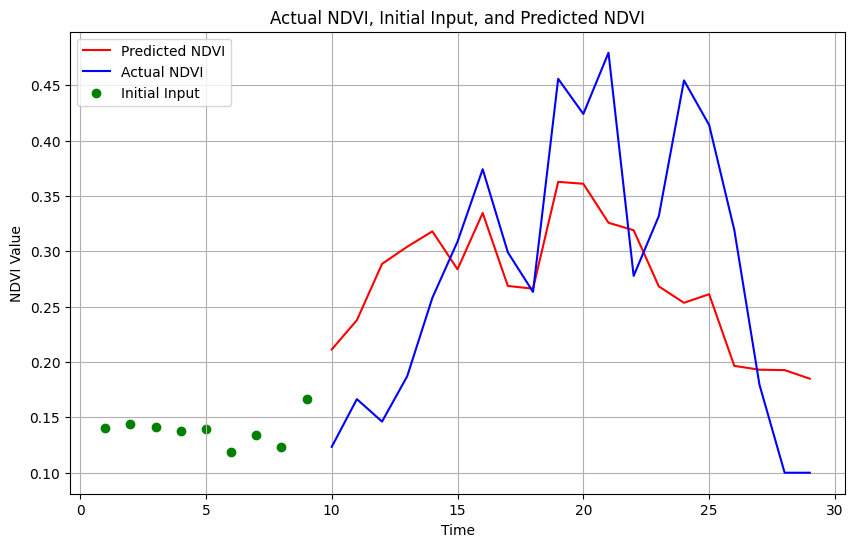

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Select initial 9 columns from both dataframes
initial_input_df1 = df_final_result.iloc[:, :9]  # Using df_x_val1 instead of df_x_val2
initial_input_df2 = ndvi_df.iloc[:, :9]

# Concatenate initial input data
initial_input = pd.concat([initial_input_df1, initial_input_df2], ignore_index=True)

# Select one sample randomly
sample_index = np.random.randint(0, min(len(df_final_result), len(ndvi_df)))
actual_values = ndvi_df.iloc[sample_index, 10:]  # Adjust index to start from where actual values begin
forecasted_values = df_final_result.iloc[sample_index, 10:]

# Define the range for x-axis
x_range_actual = range(10, 10 + len(actual_values))
x_range_forecasted = range(10, 10 + len(forecasted_values))

# Plot the actual NDVI data, initial 9 input values, and iteratively predicted data
plt.figure(figsize=(10, 6))

# Plot iteratively predicted data
plt.plot(x_range_forecasted, forecasted_values, label='Predicted NDVI', color='red')

# Plot actual NDVI data
plt.plot(x_range_actual, actual_values, label='Actual NDVI', color='blue')

# Plot initial input values
plt.scatter(range(1, 10), initial_input.iloc[sample_index, :], label='Initial Input', color='green')

plt.xlabel('Time')
plt.ylabel('NDVI Value')
plt.title('Actual NDVI, Initial Input, and Predicted NDVI')
plt.legend()
plt.grid(True)
plt.show()


# Crop Growth Stages

In [ ]:
import pandas as pd

# # Load the dataset
# df = pd.read_csv("/content/LSTM_Model_all_crops.csv")

# # Shuffle the DataFrame
# df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
dates = new_data['Transplanting']

In [ ]:
df = df_final_result
df = pd.concat([dates, df], axis=1)

In [ ]:
df

,Transplanting,CropName,NDVI_1,NDVI_2,NDVI_3,NDVI_4,NDVI_5,NDVI_6,NDVI_7,NDVI_8,...,NDVI_21,NDVI_22,NDVI_23,NDVI_24,NDVI_25,NDVI_26,NDVI_27,NDVI_28,NDVI_29,NDVI_30
0,25-10-2023,Onion,0.264023,0.264963,0.224703,0.205440,0.198123,0.204380,0.192350,0.154657,...,0.273579,0.239255,0.254824,0.262289,0.241341,0.239413,0.230631,0.209157,0.204457,0.192098
1,17-11-2023,Onion,0.140610,0.143740,0.140930,0.137513,0.139408,0.118353,0.133890,0.123348,...,0.360998,0.325762,0.319025,0.268286,0.253489,0.261247,0.196511,0.193047,0.192679,0.184917
2,20-11-2023,Onion,0.185520,0.201476,0.199977,0.177650,0.180438,0.194823,0.194951,0.157137,...,0.279080,0.241474,0.233056,0.218258,0.226521,0.216083,0.199255,0.206960,0.222638,0.222623
3,10-10-2023,Onion,0.267411,0.243527,0.252645,0.230368,0.218427,0.244505,0.202752,0.149625,...,0.181084,0.171876,0.186567,0.186622,0.188873,0.199251,0.193442,0.190683,0.202521,0.196380
4,18-10-2023,Onion,0.219379,0.214630,0.205566,0.205666,0.240842,0.216108,0.210553,0.199579,...,0.196523,0.199058,0.208810,0.204923,0.190208,0.200649,0.198366,0.192129,0.203903,0.201755


In [ ]:
df = df.head(5)

# # Extract NDVI values and replace values less than 0.1 with NaN
ndvi_df = df.iloc[4:5, 2:].mask(df.iloc[4:5, 2:] < 0.1)



# Interpolate NaN values
def interpolate_nan(row):
    for i in range(len(row)):
        if pd.isna(row[i]):
            prev_idx = i - 1
            while prev_idx >= 0 and pd.isna(row[prev_idx]):
                prev_idx -= 1
            next_idx = i + 1
            while next_idx < len(row) and pd.isna(row[next_idx]):
                next_idx += 1
            if prev_idx >= 0 and next_idx < len(row):
                interpolated_value = (row[prev_idx] + row[next_idx]) / 2
                row[i] = interpolated_value
            else:
                row[i] = 0.1
    return row

ndvi_data = ndvi_df.apply(interpolate_nan, axis=1)

In [ ]:
ndvi_data

,NDVI_1,NDVI_2,NDVI_3,NDVI_4,NDVI_5,NDVI_6,NDVI_7,NDVI_8,NDVI_9,NDVI_10,...,NDVI_21,NDVI_22,NDVI_23,NDVI_24,NDVI_25,NDVI_26,NDVI_27,NDVI_28,NDVI_29,NDVI_30
4,0.219379,0.21463,0.205566,0.205666,0.240842,0.216108,0.210553,0.199579,0.210195,0.20931,...,0.196523,0.199058,0.20881,0.204923,0.190208,0.200649,0.198366,0.192129,0.203903,0.201755


In [ ]:
df['Transplanting'].iloc[4]

'18-10-2023'

In [ ]:

# Generate list of dates starting from 2022-11-20 with a step of 5 days
start_date = pd.to_datetime(df['Transplanting'].iloc[4])
date_columns = [(start_date + pd.DateOffset(days=5 * i)).strftime('%Y-%m-%d') for i in range(len(ndvi_data.columns))]

# Create a mapping dictionary between NDVI columns and dates
column_mapping = dict(zip(ndvi_data.columns, date_columns))

# Rename columns using the mapping dictionary
ndvi_data.rename(columns=column_mapping, inplace=True)
ndvi_data['CropName'] = df['CropName']

# Define growth stages and their time differences for each crop
crop_growth_stages = {
    'Bajra': {'Sowing': 0, 'Germination': 10, 'Flowering': 50, 'Maturity': 75, 'Harvest': 90},
    'Cotton': {'Sowing': 0, 'Germination': 10, 'Flowering': 45, 'Boll formation': 75, 'Maturity': 105, 'Harvest': 120},
    'Gram': {'Sowing': 0, 'Germination': 10, 'Flowering': 40, 'Pod-filling': 50, 'Maturity': 70, 'Harvest': 85},
    'Groundnut': {'Sowing': 0, 'Germination': 10, 'Flowering': 40, 'Pod-filling': 70, 'Maturity': 85, 'Harvest': 115},
    'Maize': {'Sowing': 0, 'Germination': 10, 'Tasseling': 40, 'Silking': 55, 'Maturity': 85, 'Harvest': 100},
    'Mustard': {'Sowing': 0, 'Germination': 10, 'Flowering': 40, 'Maturity': 70, 'Harvest': 85},
    'Onion': {'Sowing': 0, 'Germination': 10, 'Bulb-forming': 60, 'Maturity': 90, 'Harvest': 110},
    'Potato': {'Sowing': 0, 'Germination': 10, 'Tuber initiation': 40, 'Tuber-bulking': 70, 'Maturity': 85, 'Harvest': 100},
    'Rice': {'Sowing': 0, 'Germination': 10, 'Panicle initiation': 60, 'Flowering': 90, 'Maturity': 110, 'Harvest': 125},
    'Soyabean': {'Sowing': 0, 'Germination': 10, 'Reproductive growth': 25, 'Flowering': 40, 'Maturity': 70, 'Harvest': 85},
    'Wheat': {'Sowing': 0, 'Germination': 10, 'Tillering': 40, 'Heading': 75, 'Maturity': 110, 'Harvest': 120}
}


# Define max NDVI stage for each crop
max_ndvi_stage = {
    'Bajra': 'Flowering',
    'Cotton': 'Boll formation',
    'Gram': 'Pod-filling',
    'Groundnut': 'Pod-filling',
    'Maize': 'Tasseling',
    'Mustard': 'Flowering',
    'Onion': 'Bulb-forming',
    'Potato': 'Tuber-bulking',
    'Rice': 'Flowering',
    'Soyabean': 'Reproductive growth',
    'Wheat': 'Heading'
}


def estimate_growth_stages(crop_data, crop_name):
    # Calculate the maximum NDVI value and its corresponding time
    max_ndvi_value = crop_data.max(axis=1)
    max_ndvi_time = crop_data.idxmax(axis=1)  # Assuming this gives the timestep index

    # Define growth stages and their time differences based on crop name
    growth_stages = crop_growth_stages[crop_name]

    # Estimate the timing of each growth stage
    estimated_growth_stages = {}

    # Append max NDVI stage and time to estimated growth stages
    max_ndvi_stage_name = max_ndvi_stage[crop_name]
    max_ndvi_stage_time = pd.to_datetime(max_ndvi_time.iloc[0])

    # Calculate time differences for stages before and after max NDVI stage
    for stage, days_difference in sorted(growth_stages.items(), key=lambda x: x[1]):
        if stage == max_ndvi_stage_name:
            estimated_growth_stages[stage] = max_ndvi_stage_time
        elif stage in crop_growth_stages[crop_name]:
            time_difference = crop_growth_stages[crop_name][max_ndvi_stage_name] - crop_growth_stages[crop_name][stage]
            if time_difference >= 0:
                estimated_time = max_ndvi_stage_time - pd.Timedelta(days=time_difference)
            else:
                estimated_time = max_ndvi_stage_time + pd.Timedelta(days=-time_difference)
            estimated_growth_stages[stage] = estimated_time

    return estimated_growth_stages


# Loop over each crop and estimate growth stages
crop_names = ndvi_data['CropName'].unique()
estimated_growth_stages_all_crops = {}
for crop_name in crop_names:
    crop_data = ndvi_data[ndvi_data['CropName'] == crop_name].drop(columns=['CropName'])
    estimated_growth_stages = estimate_growth_stages(crop_data, crop_name)
    estimated_growth_stages_all_crops[crop_name] = estimated_growth_stages


# Print the estimated growth stages for each crop
for crop_name, growth_stages in estimated_growth_stages_all_crops.items():
    print("Estimated growth stages for", crop_name)
    for stage, time in growth_stages.items():
        print(stage, ":", time)
    print()
()


Estimated growth stages for Onion
Sowing : 2023-09-08 00:00:00
Germination : 2023-09-18 00:00:00
Bulb-forming : 2023-11-07 00:00:00
Maturity : 2023-12-07 00:00:00
Harvest : 2023-12-27 00:00:00



<ipython-input-80-e63d1cd0dbc0>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  start_date = pd.to_datetime(df['Transplanting'].iloc[4])


()